In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append('/Users/Josh/Documents/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

## Import training data

In [4]:
import pickle

with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [5]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [6]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

images_all = np.concatenate(sf_list, axis=0)

images_all.shape

(217802, 36, 36)

In [7]:
images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((185131, 36, 36), (185131,)), ((32671, 36, 36), (32671,)))

<IPython.core.display.Javascript object>


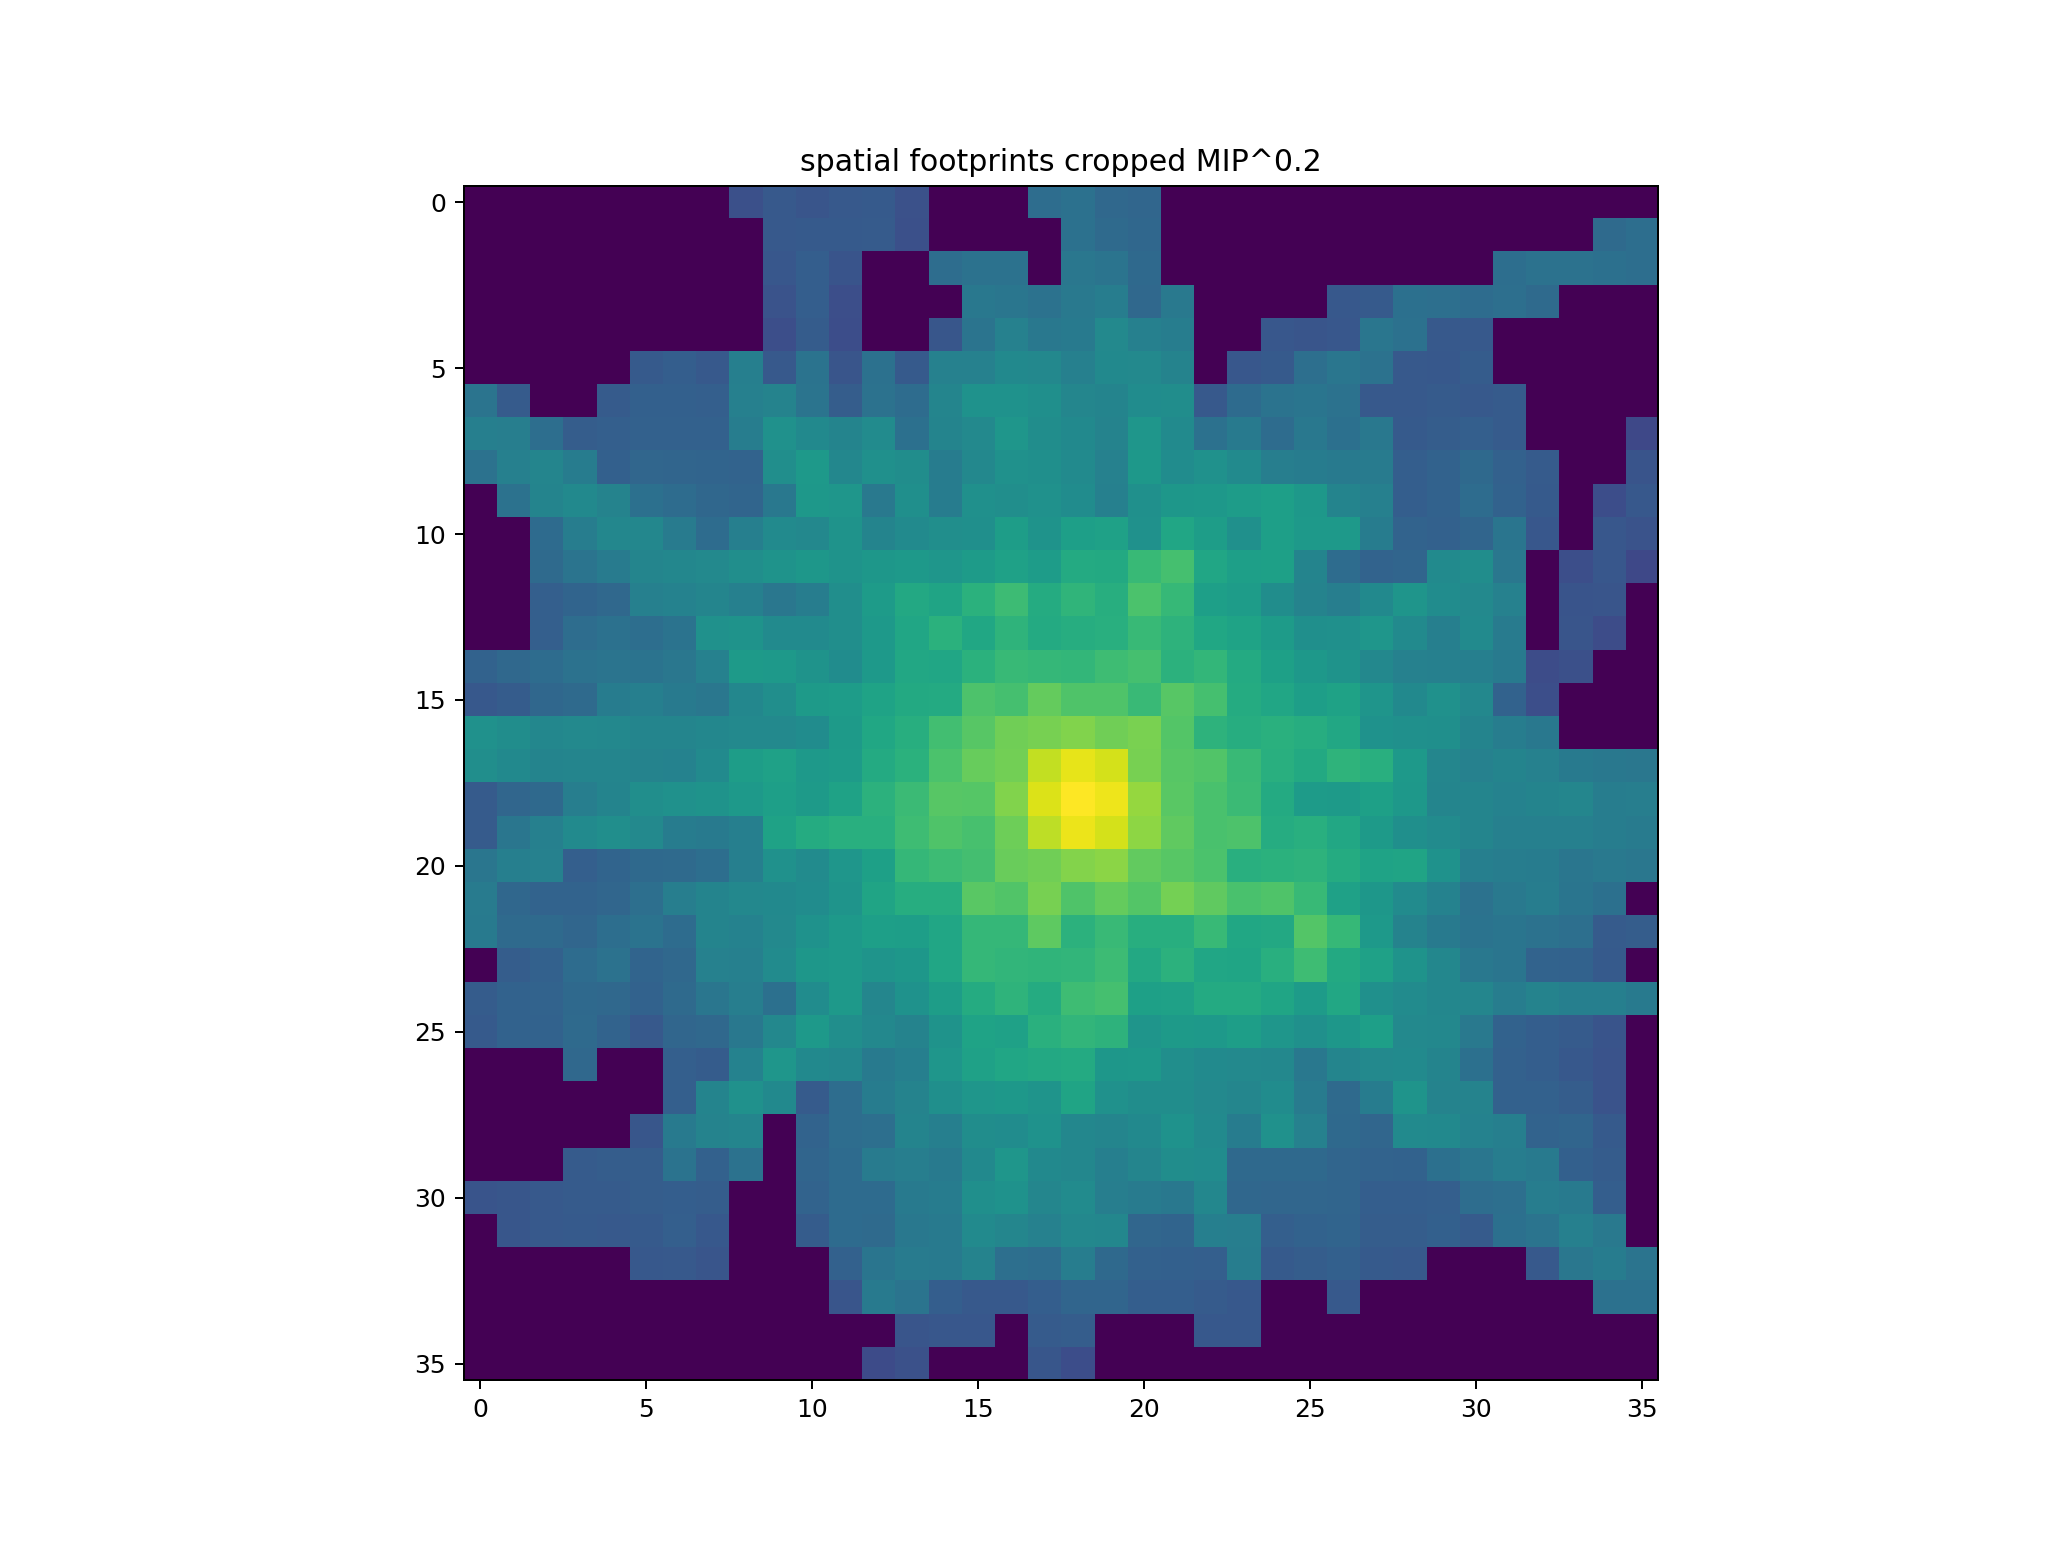

<IPython.core.display.Javascript object>


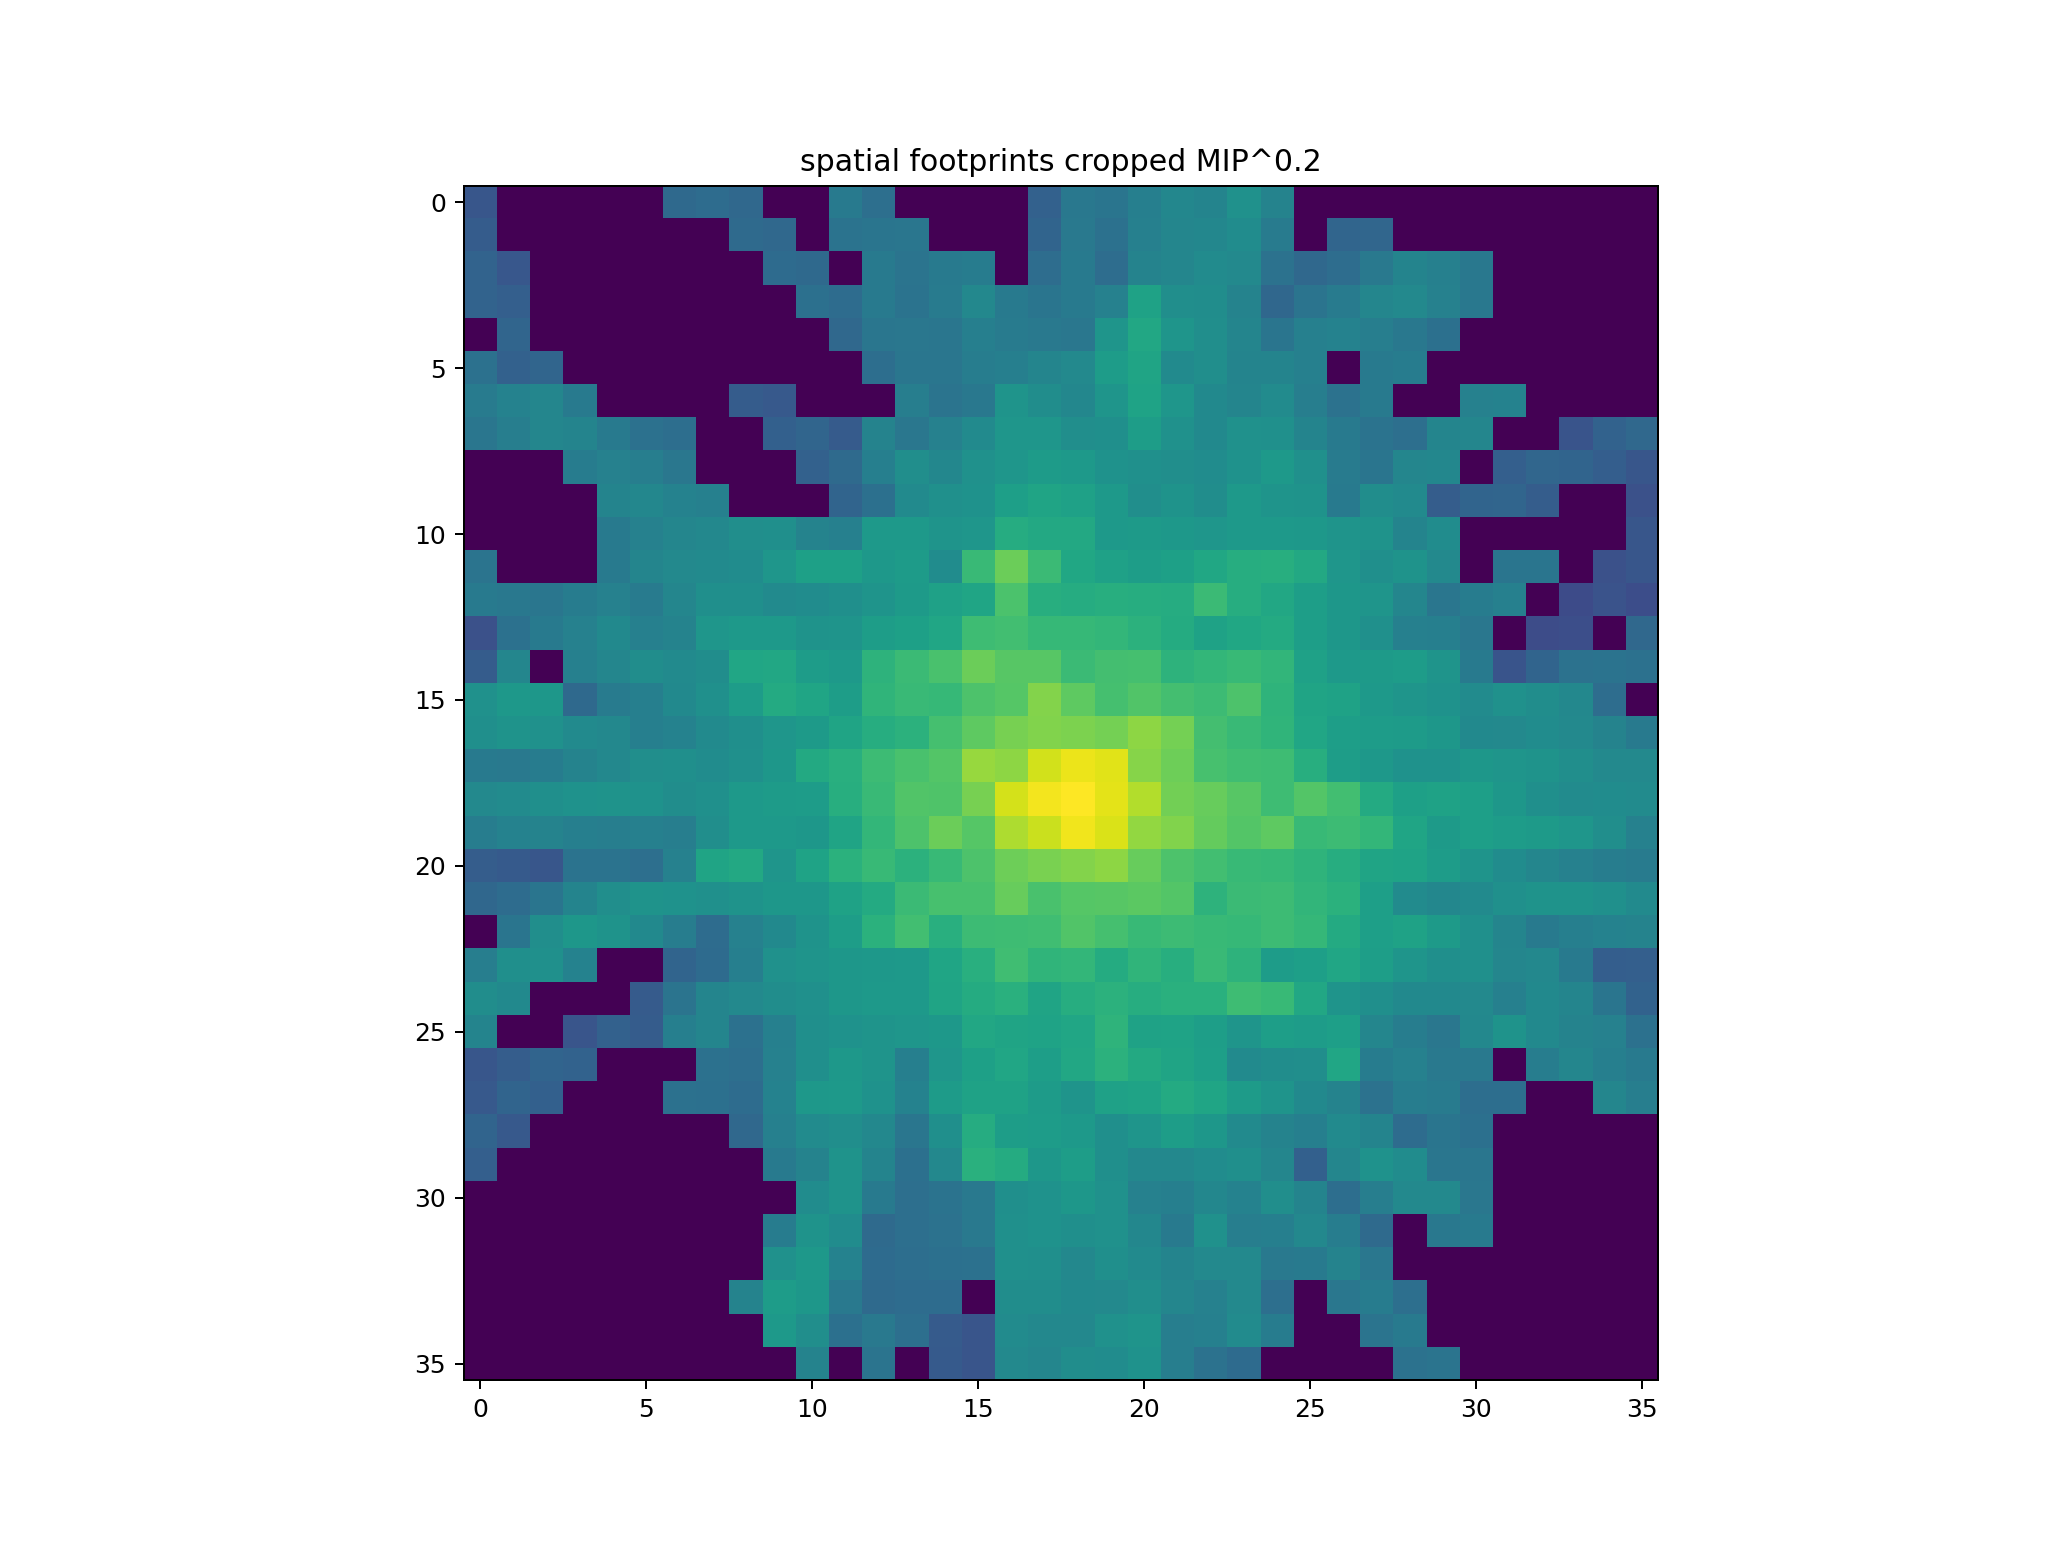

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


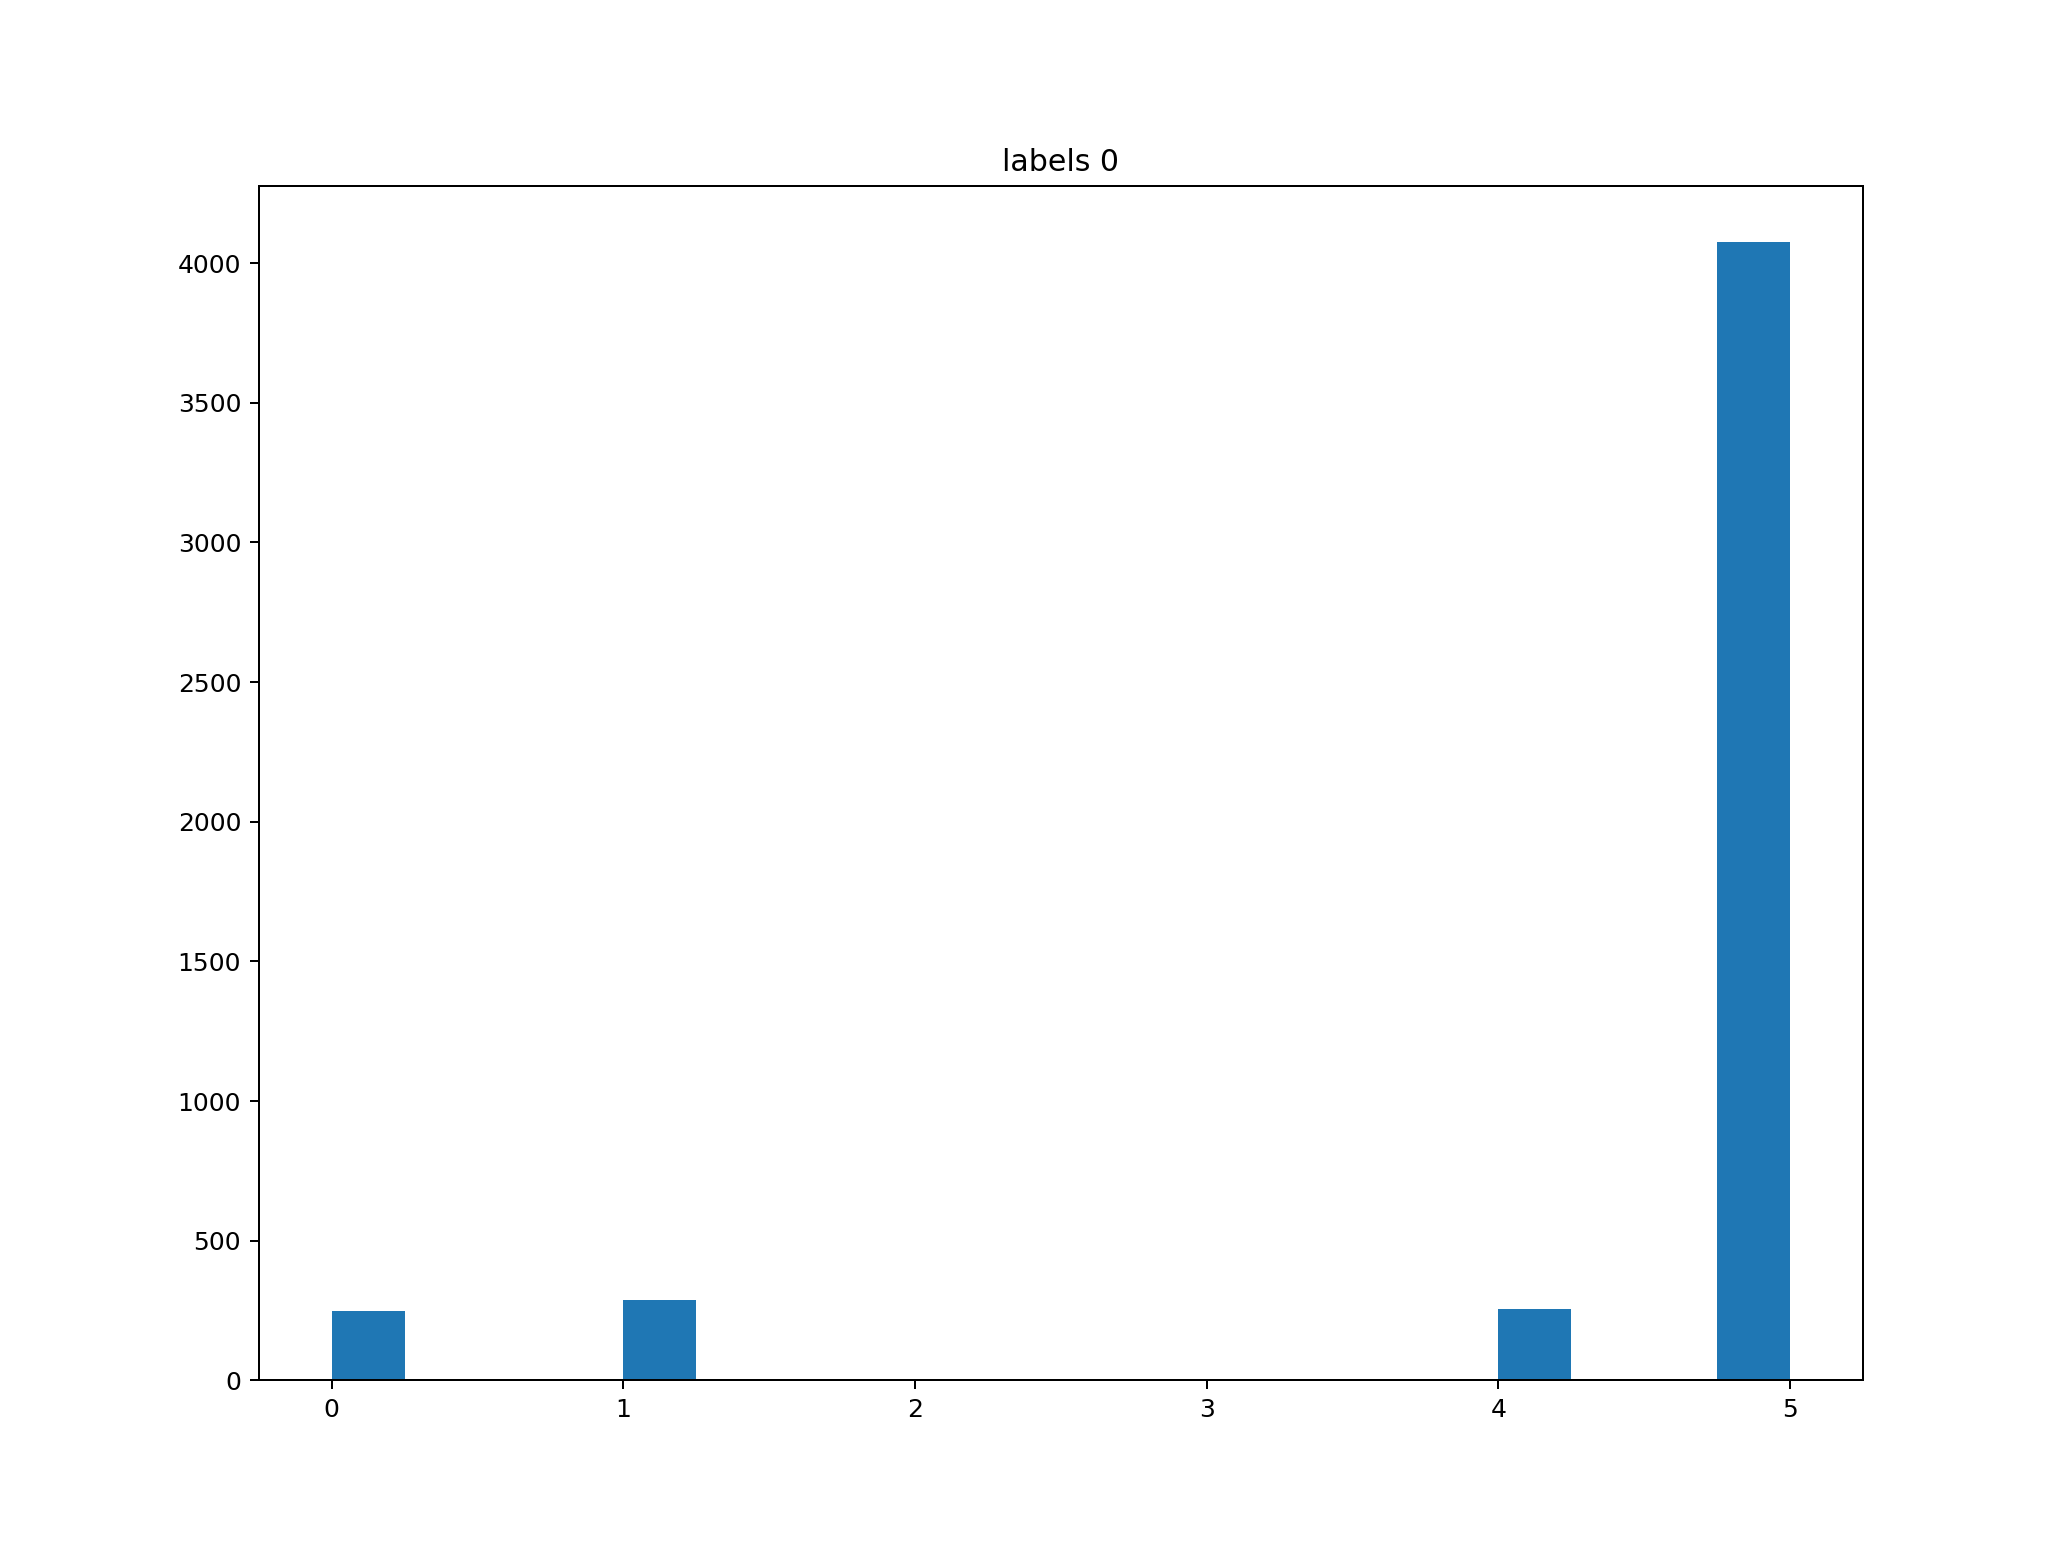

<IPython.core.display.Javascript object>


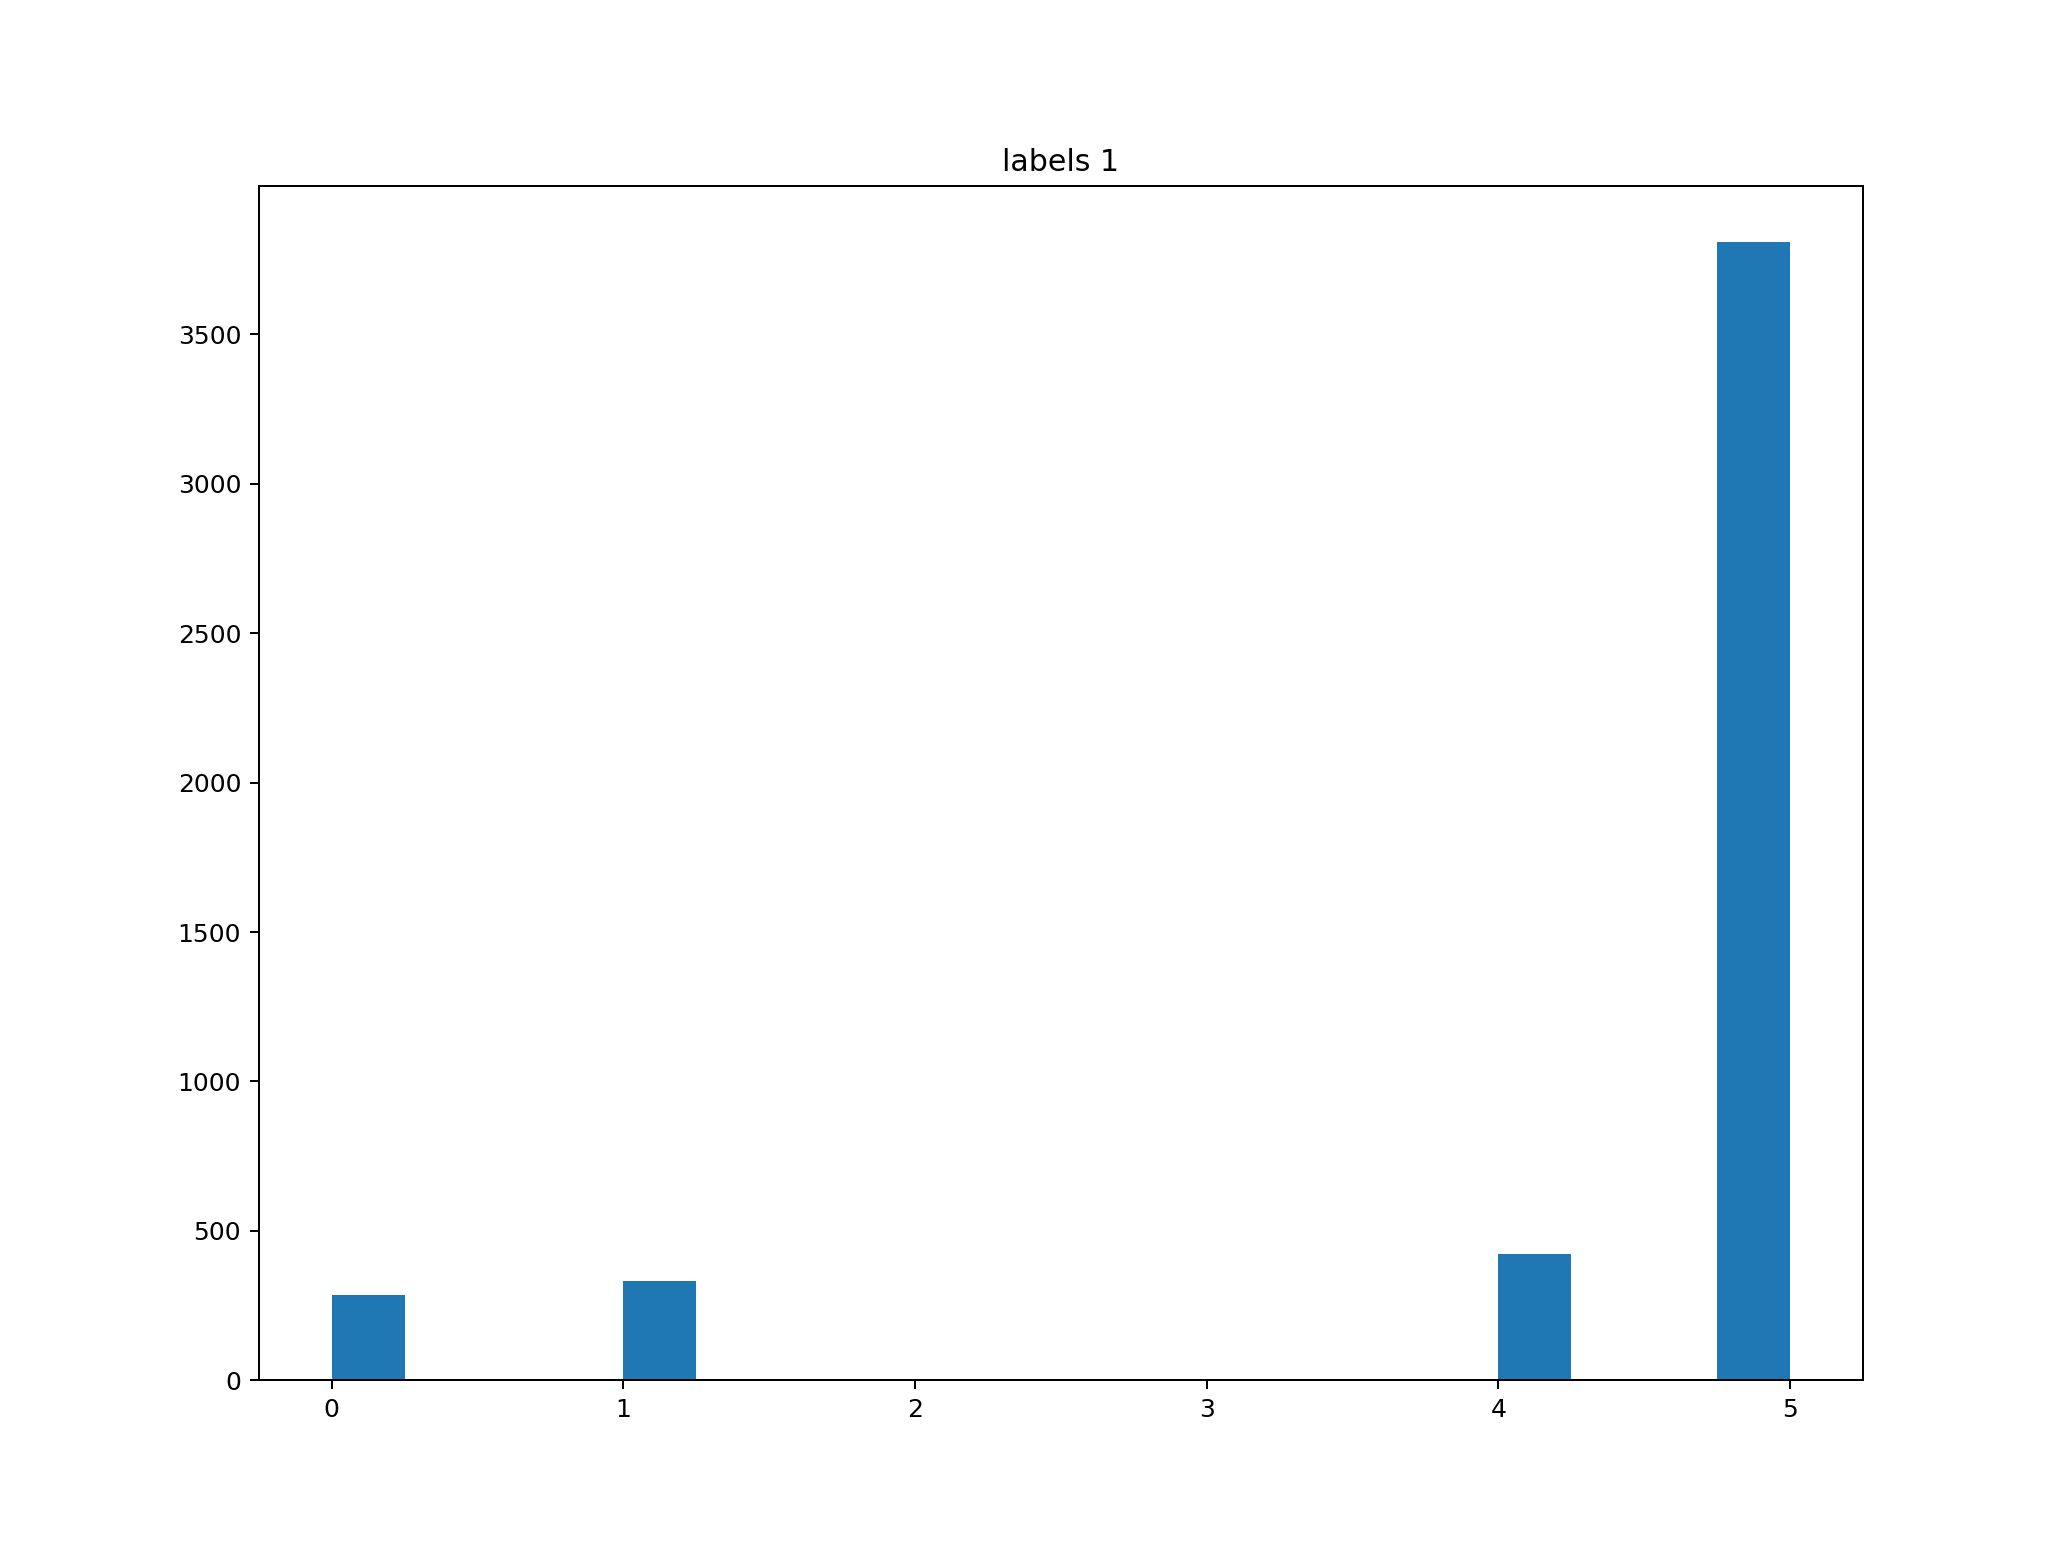

In [23]:
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

## Balance classes of inputs

In [25]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)
for ii in np.array([1,4,5]):
#     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
    if ii==5:
        numToGetTo = np.sum(labels_dup==0)/2
    else:
        numToGetTo = np.sum(labels_dup==0)

    idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
    images_dup = images_dup[idxToDelete==0,:,:]
    labels_dup = labels_dup[idxToDelete==0]


print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9715, 36, 36)
(9715,)
532
532
532
532
266
(1863, 36, 36)
(1863,)


In [27]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_dup[:], labels_dup[:], test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((1583, 36, 36), (1583,)), ((280, 36, 36), (280,)))

<IPython.core.display.Javascript object>


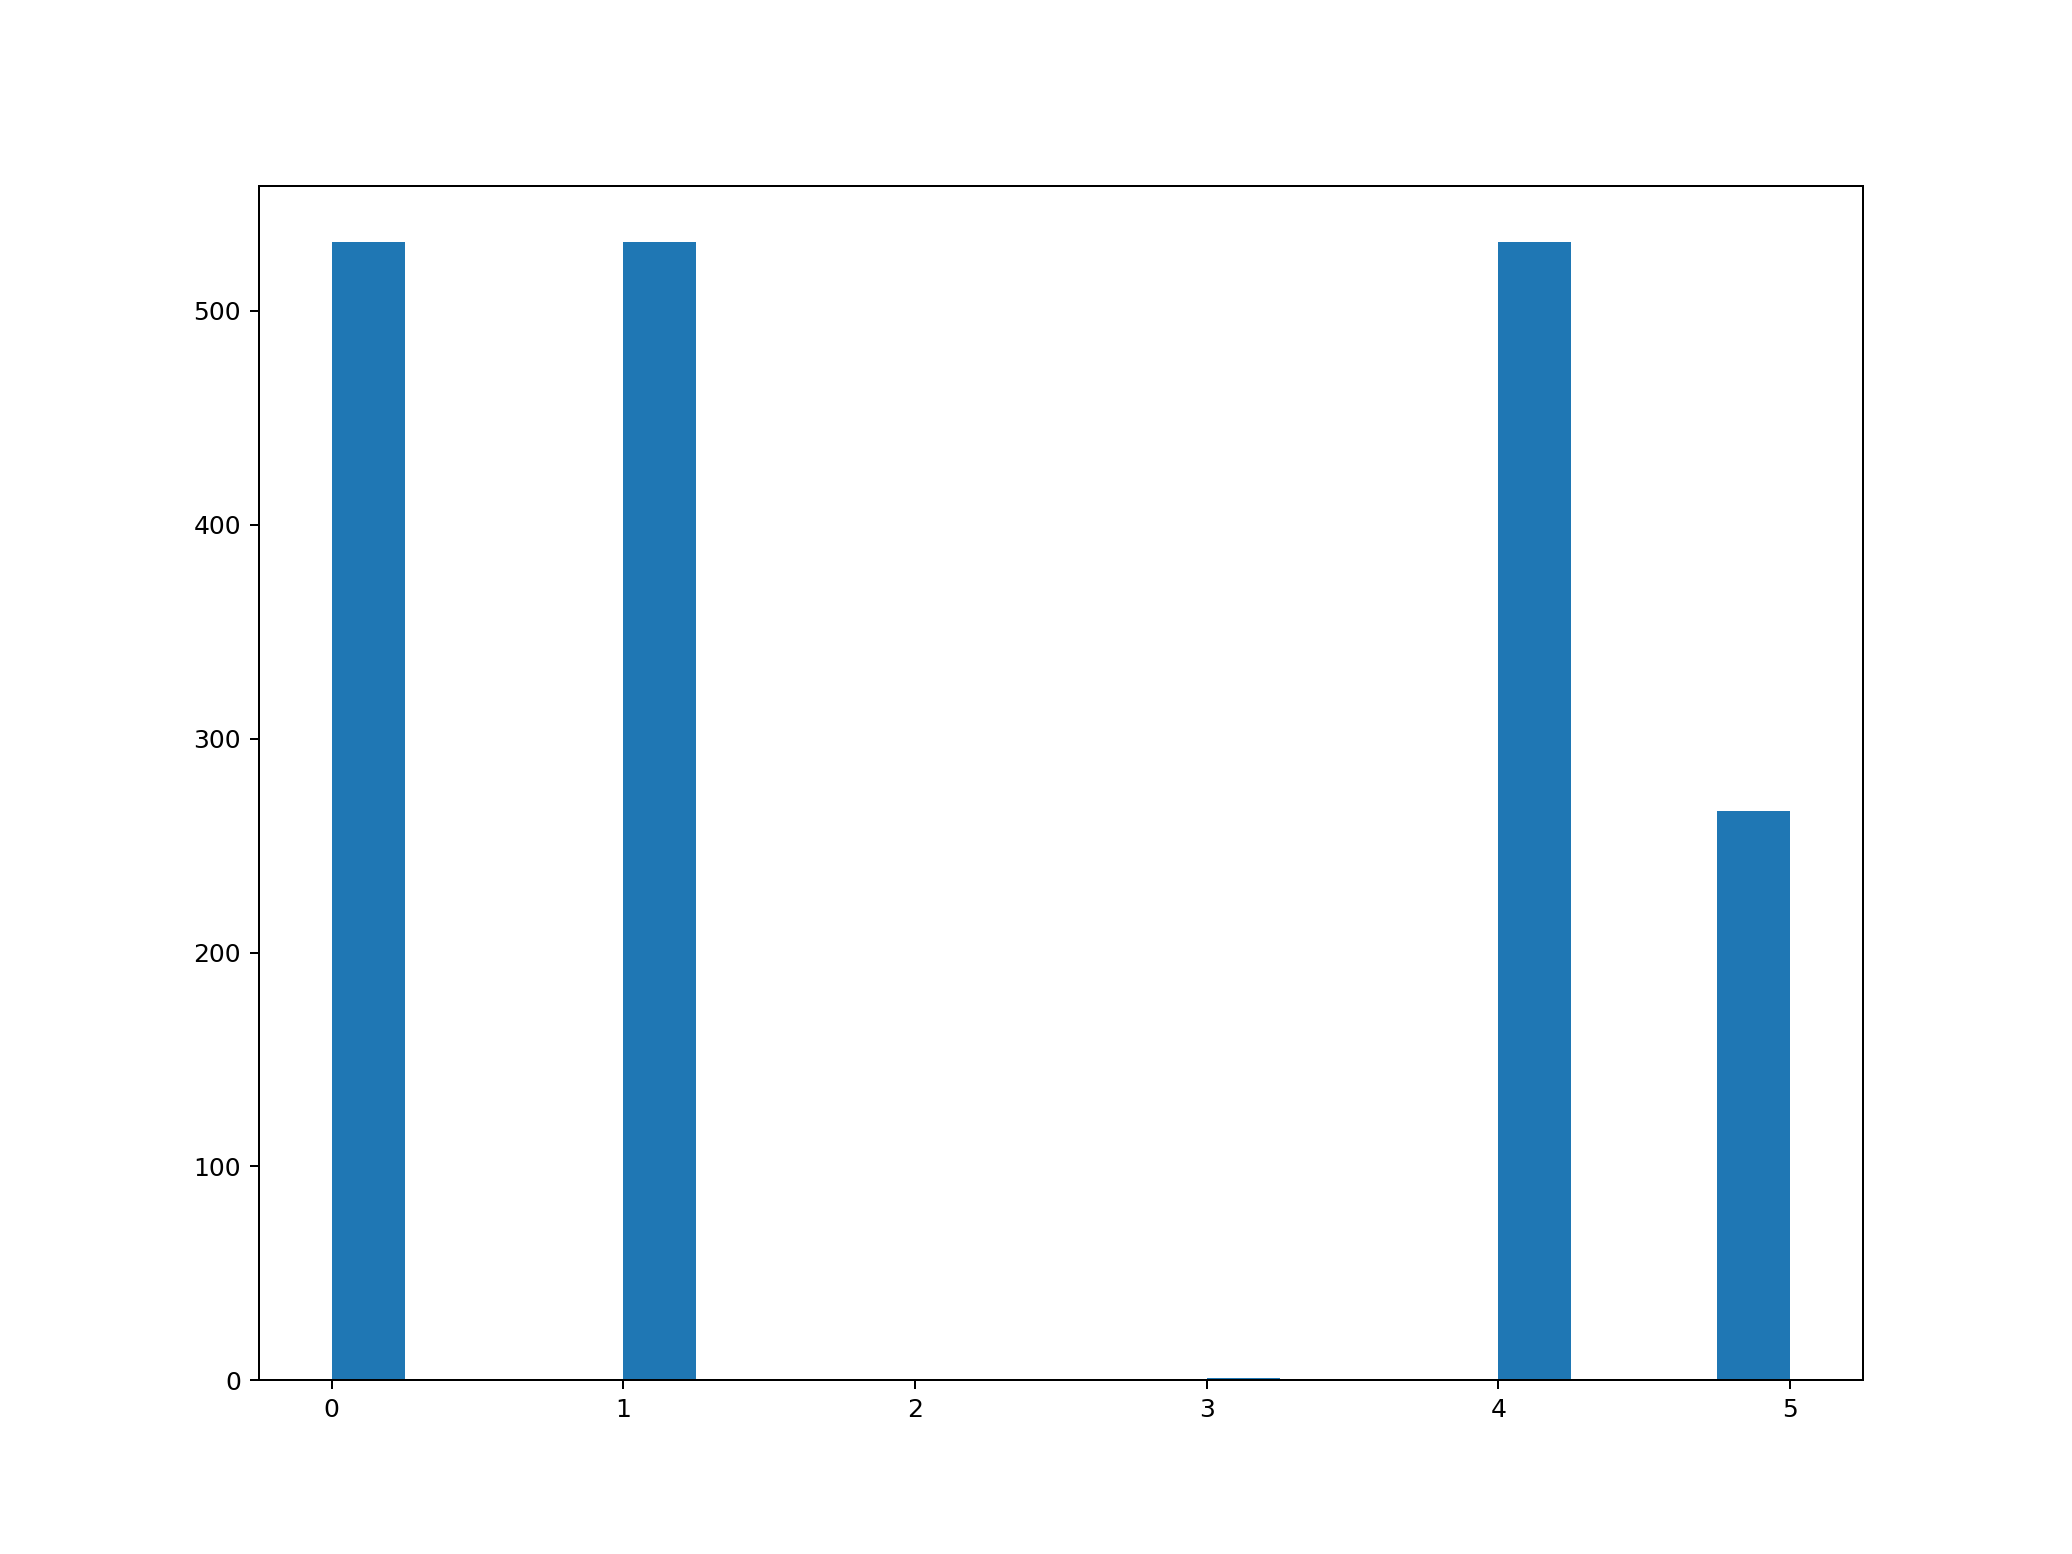

In [28]:
plt.figure()
plt.hist(labels_dup, 20);

## Define augmentation pipeline

In [10]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.5)),
    
#     torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.3, 0.3),
#                                         scale=(0.7, 1.7), 
#                                         shear=(-30, 30, -30, 30), 
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
    
#     augmentation.AddPoissonNoise(   level_bounds=(0,0.7),
#                                     prob=1),

#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.4,
#                                     prob=1),
)
# scripted_transforms = torch.jit.script(transforms)
scripted_transforms = transforms


dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1024,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=False,
#                                                 num_workers=32,
                                                num_workers=16,
                                                prefetch_factor=3,
                                                persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

## Train

In [11]:
DEVICE = torch_helpers.set_device(use_GPU=True)

no GPU available. Using CPU.


In [12]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=128)
model.train()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0005,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64)

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [13]:
# n_epochs=300000
# for epoch in range(n_epochs):
#     print(f'epoch: {epoch}')
#     training_simCLR.epoch_step( dataloader_train, 
#                                 model, 
#                                 optimizer, 
#                                 criterion, 
#                                 scheduler=scheduler, 
#                                 temperature=0.5,
#                                 loss_rolling_train=losses_train, 
#                                 device=DEVICE, 
#                                 do_validation=False,
#                                 validation_Object=val_obj,
#                                 loss_rolling_val=losses_val,
#                                 verbose=2,
#                                 verbose_update_period=10,
#                                )

In [14]:
load_mdl = torch.load('/Users/josh/Documents/Harvard/pretrained/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth',
                 map_location=torch.device('cpu'))
model.load_state_dict(load_mdl)
# model.load_state_dict('/Users/josh/Documents/Harvard/pretrained/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

<All keys matched successfully>

In [15]:
plt.figure()
plt.plot(losses_train)

<IPython.core.display.Javascript object>

In [64]:
# for v in (dataloader_train):
#     print(v)
#     print(len(v))
#     model(v)
#     break

# model(torch.tensor(X_train[:,None,:,:]).float())
tm = training_classHead.get_simCLR_interim(model, X_train[:, None, :, :])
# tm = training_classHead.get_simCLR_output(model, X_train[:, None, :, :])

In [65]:
tm.shape

(1583, 64)

In [73]:
sys.path.append('/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/')

import training_classHead


In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

PredictionClass = SVC

# logreg = training_classHead.train_Logistic(model(torch.tensor(X_train[:,None,:,:]).float()).detach().numpy(), y_train)
# logreg = training_classHead.train_logistic()
logreg = training_classHead.train_head(PredictionClass, model, X_train[:, None, :, :], y_train)

In [115]:
logreg.score(training_classHead.get_simCLR_interim(model, X_val[:,None,:,:]), y_val)

0.6392857142857142

In [117]:
prediction_proba = training_classHead.predict_head(model, logreg, X_val[:,None,...])
# prediction = np.argmax(predict_proba_vals, axis=1)
prediction

array([0, 3, 0, 0, 1, 3, 4, 1, 0, 4, 3, 3, 1, 0, 0, 1, 1, 1, 0, 3, 1, 1,
       4, 0, 0, 0, 4, 0, 4, 3, 1, 0, 0, 3, 0, 3, 3, 1, 0, 0, 3, 0, 0, 1,
       3, 3, 1, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 1, 3, 0, 3, 0,
       3, 0, 0, 4, 4, 0, 0, 0, 0, 3, 3, 1, 1, 1, 0, 1, 4, 1, 3, 3, 3, 3,
       3, 4, 4, 3, 1, 0, 0, 3, 3, 1, 0, 4, 3, 3, 3, 3, 3, 1, 3, 0, 3, 4,
       1, 0, 0, 0, 1, 1, 3, 0, 3, 3, 4, 3, 0, 3, 1, 0, 0, 0, 3, 0, 1, 3,
       3, 4, 3, 1, 0, 3, 3, 3, 1, 3, 4, 3, 3, 0, 1, 0, 0, 0, 1, 0, 0, 3,
       0, 3, 3, 4, 0, 0, 0, 0, 1, 0, 0, 4, 3, 0, 0, 0, 0, 3, 0, 3, 3, 3,
       0, 0, 3, 0, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 3, 0, 3, 0,
       3, 3, 3, 1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 1, 4, 3, 0, 3, 0, 4, 3, 3,
       3, 0, 0, 3, 0, 1, 0, 0, 1, 3, 4, 3, 0, 3, 4, 4, 4, 0, 0, 0, 3, 3,
       0, 1, 3, 1, 1, 0, 4, 0, 0, 3, 3, 0, 3, 3, 4, 4, 0, 3, 3, 0, 3, 3,
       0, 0, 0, 0, 4, 3, 1, 0, 0, 0, 3, 3, 0, 0, 3, 0])

In [118]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, prediction)

array([[64, 12,  2,  0,  0],
       [41, 22, 16,  0,  0],
       [ 0,  0,  0,  0,  0],
       [11,  8, 58,  1,  0],
       [ 0,  0, 18, 27,  0]])

In [119]:
import pandas as pd
with pd.option_context('max_rows', 3000):
    display(pd.DataFrame(np.concatenate([y_val.reshape(-1,1), prediction.reshape(-1,1)], axis=1)))

0  1
0    0  0
1    4  3
2    1  0
3    4  0
4    1  1
5    4  3
6    5  4
7    0  1
8    0  0
9    5  4
10   4  3
11   4  3
12   4  1
13   0  0
14   0  0
15   1  1
16   1  1
17   4  1
18   1  0
19   5  3
20   1  1
21   1  1
22   5  4
23   0  0
24   4  0
25   0  0
26   5  4
27   1  0
28   5  4
29   4  3
30   1  1
31   0  0
32   0  0
33   4  3
34   0  0
35   5  3
36   1  3
37   1  1
38   4  0
39   1  0
40   5  3
41   1  0
42   1  0
43   1  1
44   4  3
45   4  3
46   1  1
47   0  0
48   4  3
49   0  0
50   4  3
51   1  0
52   0  0
53   1  0
54   4  3
55   1  0
56   1  3
57   1  3
58   1  0
59   1  0
60   0  0
61   1  1
62   4  3
63   0  0
64   4  3
65   0  0
66   4  3
67   0  0
68   1  0
69   5  4
70   5  4
71   4  0
72   0  0
73   1  0
74   1  0
75   4  3
76   1  3
77   4  1
78   4  1
79   0  1
80   1  0
81   1  1
82   5  4
83   4  1
84   4  3
85   4  3
86   5  3
87   5  3
88   4  3
89   5  4
90   5  4
91   4  3
92   4  1
93   0  0
94   0  0
95   4  3
96   4  3
97   1  1
98   0  0
99   5  4
100  1  3
101  4  3
102  0  3
103  4  3
104  1  3
105  1  1
106  4  3
107  4  0
108  4  3
109  5  4
110  0  1
111  0  0
112  4  0
113  1  0
114  0  1
115  4  1
116  4  3
117  0  0
118  5  3
119  4  3
120  5  4
121  1  3
122  1  0
123  5  3
124  1  1
125  0  0
126  0  0
127  1  0
128  4  3
129  1  0
130  1  1
131  4  3
132  1  3
133  5  4
134  1  3
135  0  1
136  0  0
137  5  3
138  4  3
139  5  3
140  1  1
141  1  3
142  5  4
143  5  3
144  4  3
145  4  0
146  1  1
147  0  0
148  0  0
149  4  0
150  1  1
151  1  0
152  1  0
153  4  3
154  1  0
155  4  3
156  4  3
157  5  4
158  0  0
159  0  0
160  0  0
161  0  0
162  1  1
163  1  0
164  0  0
165  5  4
166  5  3
167  0  0
168  0  0
169  1  0
170  1  0
171  1  3
172  1  0
173  4  3
174  1  3
175  5  3
176  4  0
177  0  0
178  4  3
179  0  0
180  4  1
181  0  0
182  5  3
183  4  3
184  1  0
185  0  0
186  0  0
187  0  0
188  0  0
189  0  0
190  0  1
191  5  4
192  0  0
193  0  0
194  4  3
195  0  0
196  4  3
197  0  0
198  5  3
199  4  3
200  4  3
201  0  1
202  1  1
203  0  0
204  1  0
205  1  0
206  4  3
207  0  0
208  1  0
209  4  3
210  4  0
211  0  1
212  5  4
213  4  3
214  1  0
215  4  3
216  0  0
217  5  4
218  4  3
219  4  3
220  1  3
221  0  0
222  0  0
223  4  3
224  0  0
225  1  1
226  1  0
227  0  0
228  0  1
229  4  3
230  5  4
231  1  3
232  1  0
233  5  3
234  5  4
235  5  4
236  4  4
237  0  0
238  0  0
239  4  0
240  4  3
241  1  3
242  0  0
243  1  1
244  4  3
245  0  1
246  0  1
247  0  0
248  5  4
249  1  0
250  1  0
251  5  3
252  0  3
253  1  0
254  4  3
255  4  3
256  5  4
257  5  4
258  1  0
259  4  3
260  4  3
261  1  0
262  4  3
263  4  3
264  0  0
265  0  0
266  0  0
267  0  0
268  5  4
269  5  3
270  0  1
271  1  0
272  1  0
273  0  0
274  4  3
275  5  3
276  1  0
277  0  0
278  1  3
279  0  0

In [103]:
# training_classHead.get_simCLR_interim(model, X_val[:,None,:,:])

## Check embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [ ]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=90.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [ ]:
features_embedded

In [ ]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()